In [1]:
import uk_covid19 as cv
import pandas as pd
import numpy as np
import json

from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Get data from API. (See https://coronavirus.data.gov.uk/developers-guide#structure-metrics)
filters = ["areaType=region", "areaName=East Midlands"]
dataStructure = {   
    "date": "date", 
    "areaName": "areaName", 
    "maleCases": "maleCases",
    "femaleCases": "femaleCases"
} 

objCV19 = cv.Cov19API(filters=filters, structure=dataStructure) 

apiResult = objCV19.get_json()


`apiResult` is a python dictionary object that we need to parse into a flat dataframe. 

It has various keys but the data is stored in `apiResult["data"]`.

In [3]:
df_male = pd.json_normalize(data=apiResult["data"], record_path=["maleCases"], meta=["date", "areaName"], record_prefix="male_")
df_female = pd.json_normalize(data=apiResult["data"], record_path=["femaleCases"], meta=["date", "areaName"], record_prefix="female_")

In [4]:
df_male = df_male.rename(columns={"male_age": "age", "male_value": "maleCases", "male_rate": "maleRate"})
df_female = df_female.rename(columns={"female_age": "age", "female_value": "femaleCases", "female_rate": "femaleRate"})

In [5]:
df_male.head()

,age,maleCases,maleRate,date,areaName
0,80_to_84,1209,2128.7,2020-11-05,East Midlands
1,85_to_89,1042,3394.2,2020-11-05,East Midlands
2,40_to_44,2688,1857.8,2020-11-05,East Midlands
3,70_to_74,1301,1035.3,2020-11-05,East Midlands
4,50_to_54,3216,2034.5,2020-11-05,East Midlands


In [6]:
df_male = df_male.set_index(["date", "areaName", "age"])
df_female = df_female.set_index(["date", "areaName", "age"])

In [7]:
df = pd.concat([df_male, df_female], axis=1, join='inner')

In [8]:
df["malePop"] = (100000 / df["maleRate"]) * df["maleCases"]
df["femalePop"] = (100000 / df["femaleRate"]) * df["femaleCases"]

df["TotalRate"] = (df["maleCases"]+df["femaleCases"])/(df["malePop"]+df["femalePop"])*100000
df.head()

maleCases  maleRate  femaleCases  \
date       areaName      age                                          
2020-11-05 East Midlands 80_to_84       1209    2128.7         1274   
                         85_to_89       1042    3394.2         1266   
                         40_to_44       2688    1857.8         3264   
                         70_to_74       1301    1035.3         1130   
                         50_to_54       3216    2034.5         3879   

                                   femaleRate        malePop      femalePop  \
date       areaName      age                                                  
2020-11-05 East Midlands 80_to_84      1820.6   56795.227134   69976.930682   
                         85_to_89      2786.2   30699.428437   45438.231283   
                         40_to_44      2167.2  144687.264506  150609.080842   
                         70_to_74       845.3  125664.058727  133680.350172   
                         50_to_54      2384.6  158073.236667  162668.791412   

                                     TotalRate  
date       areaName      age                    
2020-11-05 East Midlands 80_to_84  1958.631960  
                         85_to_89  3031.351382  
                         40_to_44  2015.602324  
                         70_to_74   937.363566  
                         50_to_54  2212.058096

rate = cases / pop * 100000 

rate/100000 = cases/pop

pop = 100000/rate * cases

In [9]:
# Dataframe was combined using a key made of date, areaName and age,  we now want to reset the index so those columns are available.
df = df.reset_index()

# Remove dates older than 62 days ago and the newest few depending on time of day.

earliestDate = date.today() - timedelta(days=62)
earliestDate = earliestDate.strftime('%Y-%m-%d')

now = datetime.now()

current_time = now.strftime("%H:%M:%S")

if current_time < "17:00:00":
    timeDeltaDays = 4
else:
    timeDeltaDays = 3

latestDate = date.today() - timedelta(days=timeDeltaDays)
latestDate = latestDate.strftime('%Y-%m-%d')

df = df[(df["date"] >= earliestDate) & (df["date"] < latestDate)]

df = df.sort_values(by=["date", "age"])

df.tail(20)

,date,areaName,age,maleCases,maleRate,femaleCases,femaleRate,malePop,femalePop,TotalRate
44,2020-11-03,East Midlands,90+,685,5091.8,1534,5086.9,13453.002867,30155.890621,5088.411612
35,2020-11-04,East Midlands,0_to_4,789,569.2,754,574.6,138615.600843,131221.719457,571.826017
19,2020-11-04,East Midlands,10_to_14,1031,685.4,1057,731.5,150423.110592,144497.607656,707.986883
36,2020-11-04,East Midlands,15_to_19,4305,2985.1,5668,4103.3,144216.274162,138132.722443,3532.153512
20,2020-11-04,East Midlands,20_to_24,5368,3821.0,6171,4620.8,140486.783565,133548.303324,4210.774661
23,2020-11-04,East Midlands,25_to_29,3302,2013.0,3963,2626.9,164033.780427,150862.233050,2307.110820
32,2020-11-04,East Midlands,30_to_34,3161,1977.1,3619,2369.6,159880.633251,152726.198515,2168.858550
22,2020-11-04,East Midlands,35_to_39,2897,1986.8,3336,2199.1,145812.361586,151698.422082,2095.050110
34,2020-11-04,East Midlands,40_to_44,2687,1857.1,3262,2165.9,144687.954337,150607.137910,2014.594945
25,2020-11-04,East Midlands,45_to_49,2841,2090.4,3604,2594.6,135907.003444,138903.877284,2345.249207


In [10]:
df["ageType"] = df["age"].str.find("_")

df = df[df["ageType"] != 1]
df.head(20)

df["ageStart"] = df["age"].str[:2]


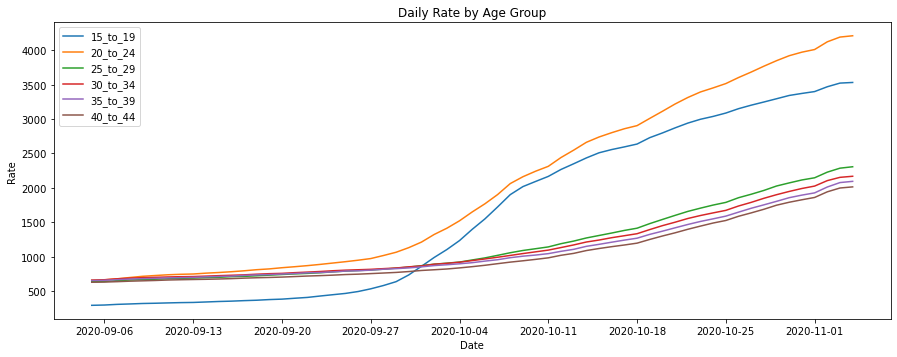

In [11]:
# Create figure.
fig = plt.figure(figsize=[15,12])
fig.set_grid = True
ax1 = fig.add_subplot(2,1,1)

locator = mdates.DayLocator(interval = 7)

ax1.set_title("Daily Rate by Age Group")
ax1.set_xlabel("Date")
ax1.set_ylabel("Rate")

ax1.xaxis.set_major_locator(locator)

#ages = list(df.age.unique())
#ages.remove("90+")

ages = list(["15_to_19" , 
            "20_to_24",
            "25_to_29",
            "30_to_34",
            "35_to_39",
            "40_to_44"])


for a in ages:
    dfByAge = df.loc[df["age"] == a]
    ax1.plot(dfByAge["date"], dfByAge["TotalRate"], label=a)

ax1.legend(loc="upper left")
fig.show()